<h1 align="center"> Varitional Autoencoder</h1>

First let's define the generative model. The generative A model for the probability distribution of a data $X$ (e.g. Multinomial, Gaussian, ..etc). Computational equivalent: a model that can be used to **generate** data with a distribution similar to the given data $X.$
<img src="images/G_Model.jpg"></img> <h4 align="center">It takes in random seeds and outputs random samples like $X.$ </h4>


**Varitional Autoencoder** is a directed generative model. It has both observed and latent variables and gives us a latent space to sample from.

**VAE consists of :**<br>
**1- The Decoder:** is a non-linear gaussian model (NLGM) and is the actual generative model.<br>
**2- The Encoder:** is a module that generates the samples of $Z$ (latent space) needed to complete the data, in order to estimate the parameters of the NLGM (Decoder), also can be used to generate the approximated distribution of the latent space representations conditional on specific inputs (Much similar to the Autoencoder).


**Learning a generative model for data:**
- Given set of observation $X$ = { $x$ }
- Choose a model $P(X|θ)$ for the distribution of $X$
- Estimate $θ$ such that $P(X|θ)$ best fit to data (Results in maximum log likelihood estimation)

To get a sample same as our data, we must learn the distribution of the data, then sample from it.
<img src="images/VAE_STR.jpg"></img>

- **$Z$** is the latent space representation of the data.
- **$μ(x; φ)$** can be also used as an expected latent representation of **$X$**.
- **$f(z; θ)$** is generally modulled by neural network.
- **$μ(x; φ)$** & **$∑(x; φ)$** are moduled by a common network with two output.
<br>

<img src="images/VAE Architecture.jpg">
<h6 align="center"> <a href="https://cedar.buffalo.edu/~srihari/CSE676/21.3-VAE-Apps.pdf" align="center">Source</a> </h6>

### `Import the needed functions`

In [29]:
import os
import numpy as np 
import pandas as pd
from collections import namedtuple
from tqdm import tqdm 
import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.datasets import MNIST 
from torchvision.transforms import transforms as T
from torchvision.utils import save_image, make_grid
from torchsummary import summary

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### `Parameter class`

In [14]:
class Parameters:
    def __init__(self):
        self.input_shape = 28 * 28
        self.encoder_dim = 512 
        self.latent_dim = 32
        self.n_epochs = 20
        self.lr = 0.001
        self.batch_size = 128
        
MNIST_P = Parameters()

### `Downloading the data`

In [24]:
mnist_data = MNIST(root=r'MNIST',
                   download=False,
                   train=True,
                   transform=T.ToTensor()
                  )
# Data loader
mnist_dataloder = torch.utils.data.DataLoader(dataset=mnist_data,
                                              batch_size=MNIST_P.batch_size, 
                                              shuffle=True)

### `Model Class`

In [25]:
class MNIST_VAE(nn.Module):
    def __init__(self, MNIST_P):
        super(MNIST_VAE, self).__init__()
        # input layer
        self.input_net = nn.Sequential(
            nn.Linear(MNIST_P.input_shape, MNIST_P.encoder_dim),
            nn.ReLU()
        )
        # encoder layers (mu and std)
        self.mu_net = nn.Linear(MNIST_P.encoder_dim, MNIST_P.latent_dim)
        self.var_net = nn.Linear(MNIST_P.encoder_dim, MNIST_P.latent_dim)
        
        self.decoder_net = nn.Sequential(
            nn.Linear(MNIST_P.latent_dim, MNIST_P.encoder_dim),
            nn.ReLU(),
            nn.Linear(MNIST_P.encoder_dim, MNIST_P.input_shape),
            nn.Sigmoid()
        )
        
    def encoder(self, x):
        input_ = self.input_net(x)
        mu, var = self.mu_net(input_), self.var_net(input_)
        return mu, var
    
    def reparameterize(self, mu, var):
        # normal distribution with mean 0 and variance 1
        std = torch.exp(var/2)
        rand_normal = torch.randn_like(std)
        return mu + rand_normal * std

    def decoder(self, z):
        decoded = self.decoder_net(z)
        return decoded
    
    def forward(self, x):
        mu, var = self.encoder(x)
        latent_space = self.reparameterize(mu, var)
        decoded = self.decoder_net(latent_space)
        return decoded, mu, var
    
print(summary(MNIST_VAE(MNIST_P), (1, 28*28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         401,920
              ReLU-2               [-1, 1, 512]               0
            Linear-3                [-1, 1, 32]          16,416
            Linear-4                [-1, 1, 32]          16,416
            Linear-5               [-1, 1, 512]          16,896
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 784]         402,192
           Sigmoid-8               [-1, 1, 784]               0
Total params: 853,840
Trainable params: 853,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.26
Estimated Total Size (MB): 3.29
----------------------------------------------------------------
None


### `Criterion Function`

In [26]:
# Compute reconstruction loss and kl divergence
def Criterion(x_reconst, x, var, mu):
    decoder_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
    kl_div = - 0.5 * torch.sum(1 + var - mu.pow(2) - var.exp())
    return decoder_loss , kl_div

### `Model Trainer`

In [27]:
#########################################
#            Trainer Class              #
#########################################

class Trainer:
    
    def __init__(self, model, optimizer, criterion, scheduler, load_path=None):
        self.__class__.__name__ = "PyTorch Trainer"
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler

        # Create a directory to save images if not exists
        sample_dir = 'model ouput'
        try: os.makedirs(sample_dir)
        except: pass
        
        # if model exist
        if load_path: self.model = torch.load(load_path)
        
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        
        
    def display_volumes(
        self,
        x,
        path
    ):
        def show(
            img, 
            label=None, 
            alpha=0.5
        ):
            plt.figure(figsize=(20,8))
            npimg = img.numpy()
            img = plt.imshow(
                np.transpose(
                    npimg, 
                    (1, 2, 0)), 
                interpolation="none"
            )
            plt.savefig(path)

        cmap_vol = np.apply_along_axis(cm.viridis, 0, x.numpy())
        cmap_vol = torch.from_numpy(np.squeeze(cmap_vol))

        show(make_grid(cmap_vol))
    
    def run(self, train_loader):                
        
        for epoch in range(MNIST_P.n_epochs):
            lr = self.optimizer.param_groups[0]['lr'] if not self.scheduler else self.scheduler.get_last_lr()[0]
            data_iter = iter(train_loader)
            prog_bar = tqdm(range(len(train_loader)))
            for step in prog_bar: # iter over batches
                ######################
                # Get the data ready #
                ######################
                # get the input images and their corresponding labels
                images, _ = data_iter.next() # no need for labels

                # wrap them in a torch Variable and move tnsors to the configured device
                images = Variable(images).to(device).view(-1, MNIST_P.input_shape)                                  
                
                ################
                # Forward Pass #
                ################
                # Feed input images
                x_decoded, mu, var = model(images)
                
                # Find the Loss
                # Backprop and optimize
                decoder_loss , kl_div = self.criterion(x_decoded, images, mu, var)
                loss = decoder_loss + kl_div
                
                #################
                # Backward Pass #
                #################
                # Calculate gradients
                loss.backward()
                # Update Weights
                self.optimizer.step()
                # clear the gradient
                self.optimizer.zero_grad()

                prog_bar.set_description('Epoch {}/{}, Decoder Loss: {:.4f}, KL Div: {:.4f}, lr={:.4f}'\
                                         .format(epoch+1, MNIST_P.n_epochs, decoder_loss, kl_div ,lr))

            # see model's performace each epoch
            with torch.no_grad():
                # Save the sampled images
                z = torch.randn(MNIST_P.batch_size, MNIST_P.latent_dim).to(device)
                out = model.decoder(z).view(-1, 1, 28, 28)
                self.display_volumes(out, os.path.join('model ouput', 'Epoch-{} Sampled.png'.format(epoch+1)))

                # Save the decoded images
                out, _, _ = model(images)
                image_cat = torch.cat([images.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
                self.display_volumes(image_cat, os.path.join('model ouput', 'Epoch-{} Decoded.png'.format(epoch+1)))

                
            # Decrease the lr
            if self.scheduler:
                scheduler.step()

Epoch 1/20, Decoder Loss: 9924.7754, KL Div: 1637.9915, lr=0.0010: 100%|█████████████| 469/469 [00:26<00:00, 17.47it/s]
Epoch 2/20, Decoder Loss: 8678.8379, KL Div: 1805.9833, lr=0.0010: 100%|█████████████| 469/469 [00:23<00:00, 19.89it/s]
Epoch 3/20, Decoder Loss: 9261.3926, KL Div: 1834.4480, lr=0.0010: 100%|█████████████| 469/469 [00:21<00:00, 21.74it/s]
Epoch 4/20, Decoder Loss: 8128.3433, KL Div: 1901.9543, lr=0.0010: 100%|█████████████| 469/469 [00:21<00:00, 21.97it/s]
Epoch 5/20, Decoder Loss: 8080.3135, KL Div: 1846.0405, lr=0.0010: 100%|█████████████| 469/469 [00:21<00:00, 21.71it/s]
Epoch 6/20, Decoder Loss: 7903.9971, KL Div: 1832.4347, lr=0.0010: 100%|█████████████| 469/469 [00:21<00:00, 22.12it/s]
Epoch 7/20, Decoder Loss: 8000.4170, KL Div: 1853.4491, lr=0.0010: 100%|█████████████| 469/469 [00:21<00:00, 22.11it/s]
Epoch 8/20, Decoder Loss: 8145.5161, KL Div: 1864.1251, lr=0.0010: 100%|█████████████| 469/469 [00:21<00:00, 21.89it/s]
Epoch 9/20, Decoder Loss: 7568.1904, KL 

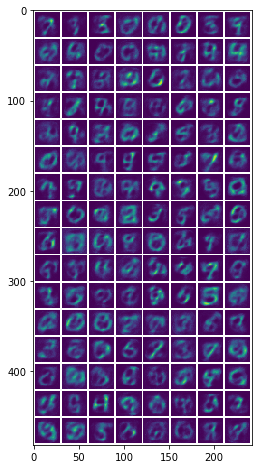

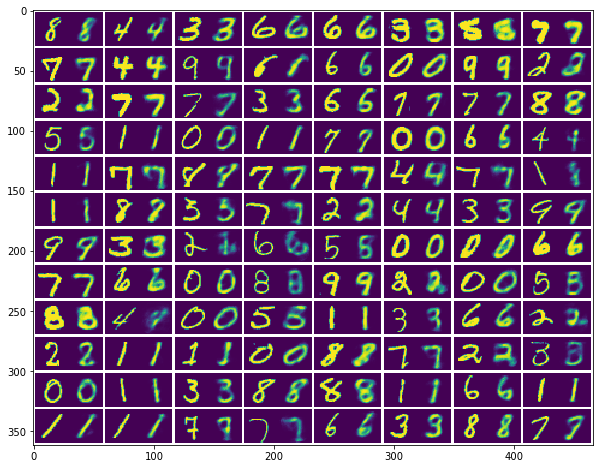

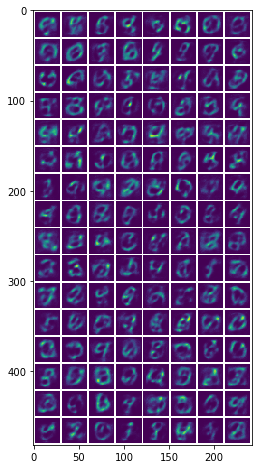

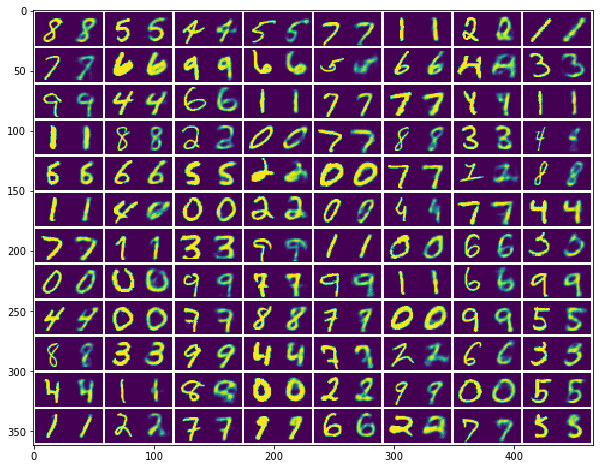

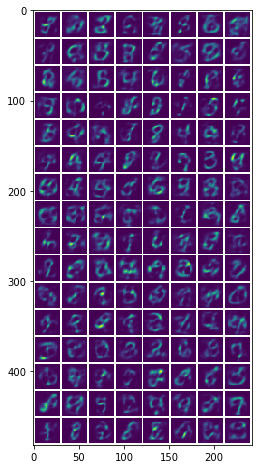

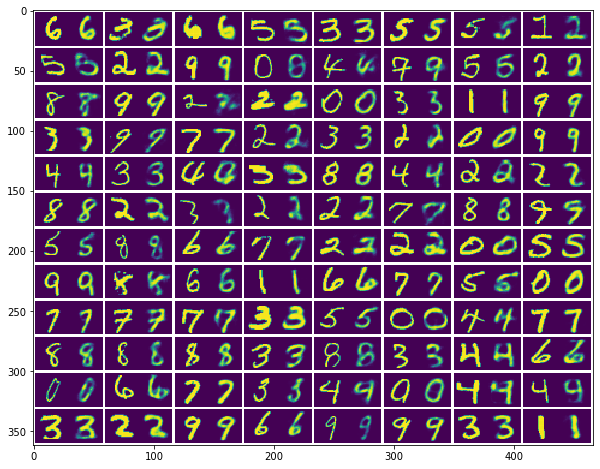

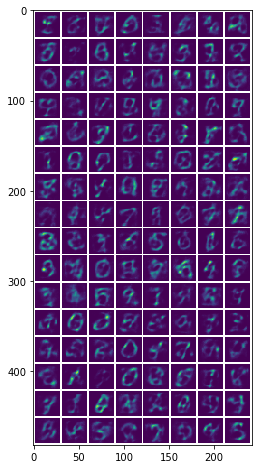

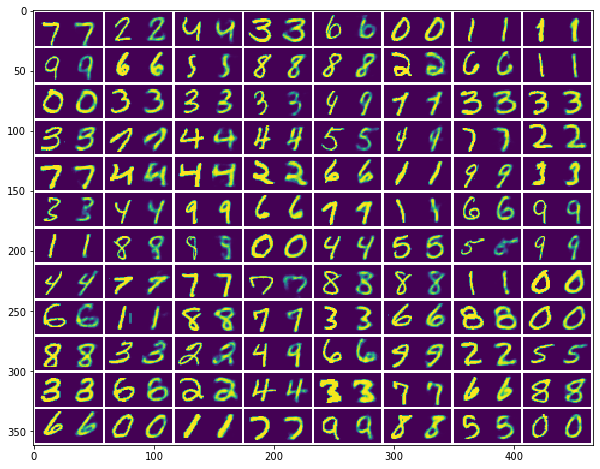

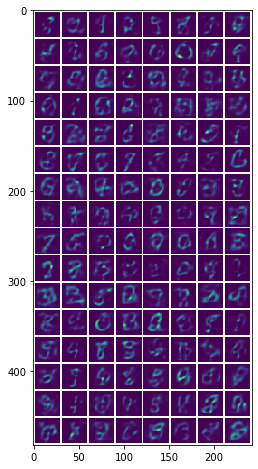

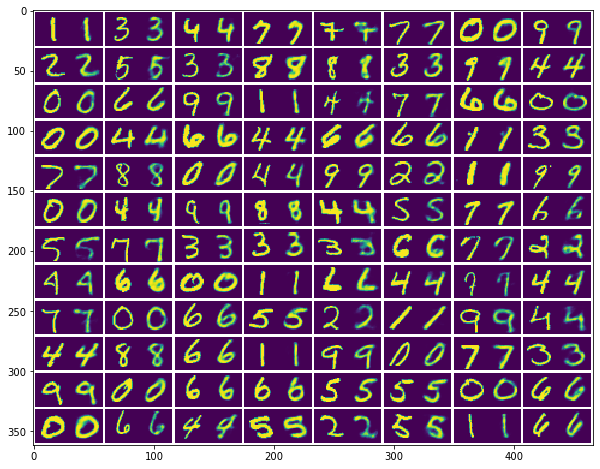

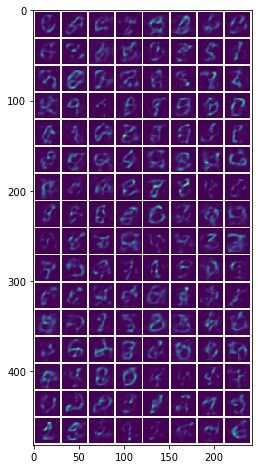

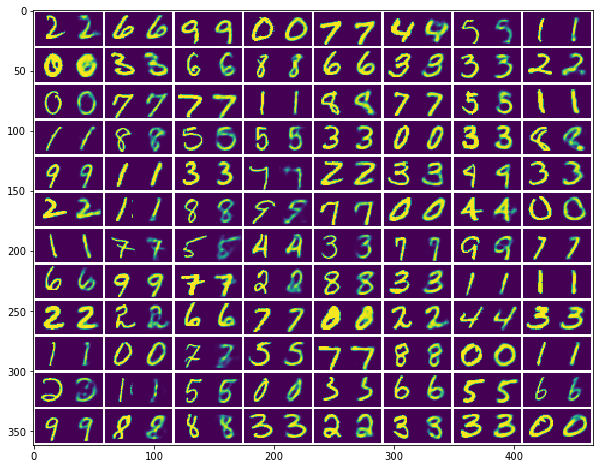

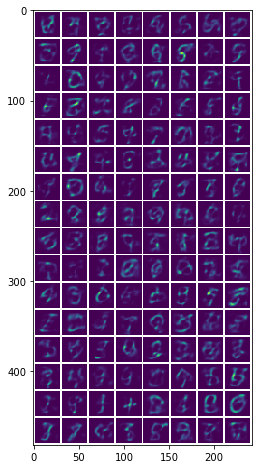

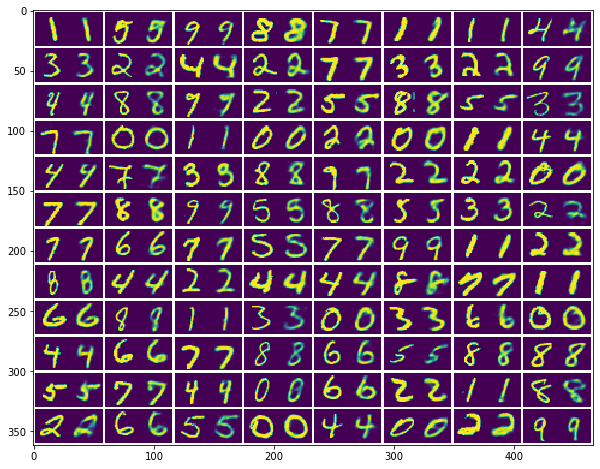

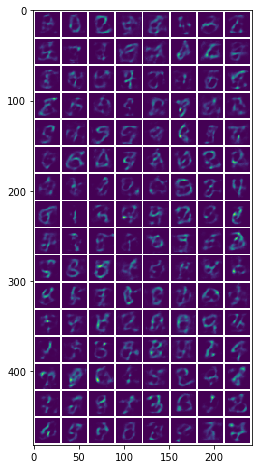

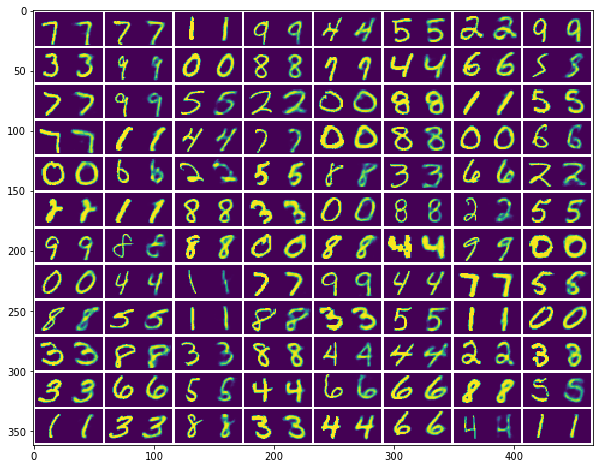

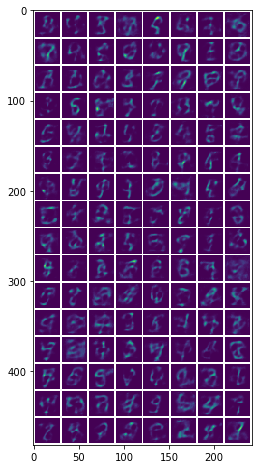

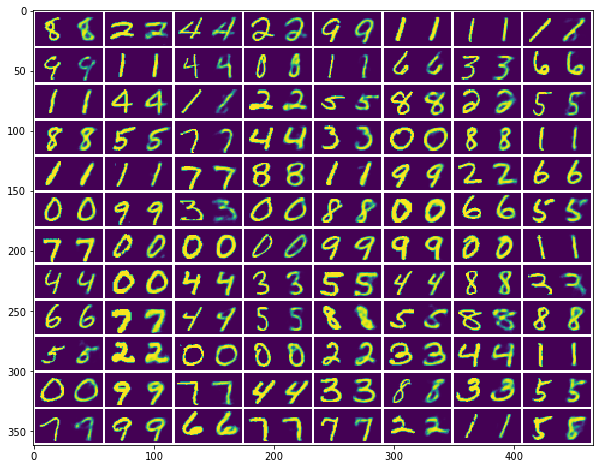

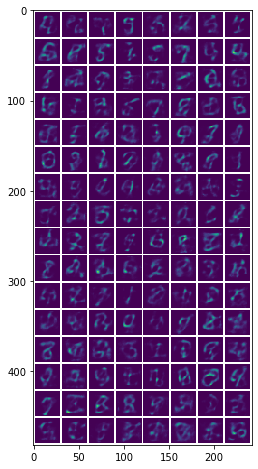

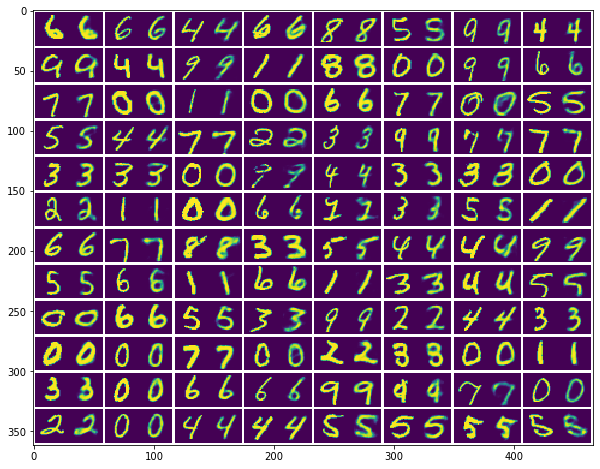

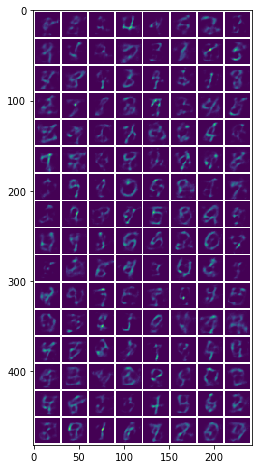

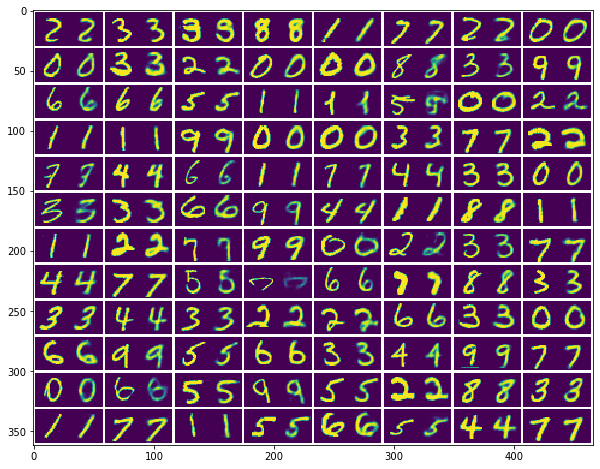

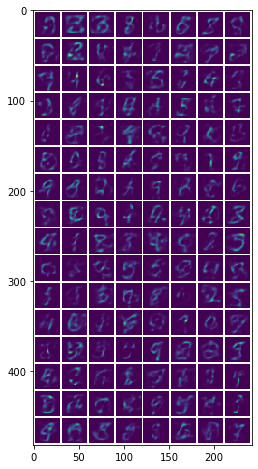

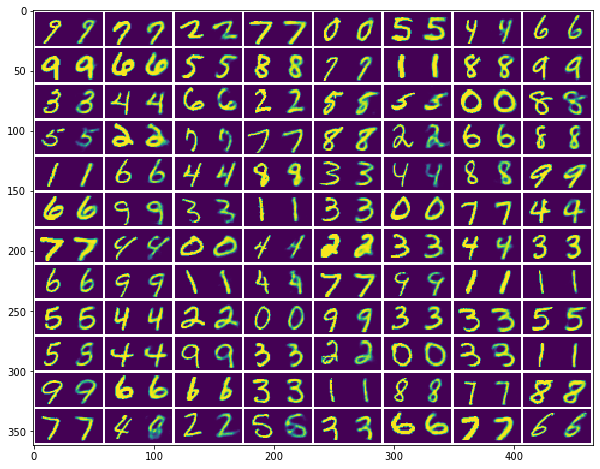

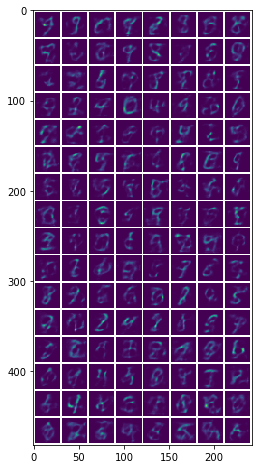

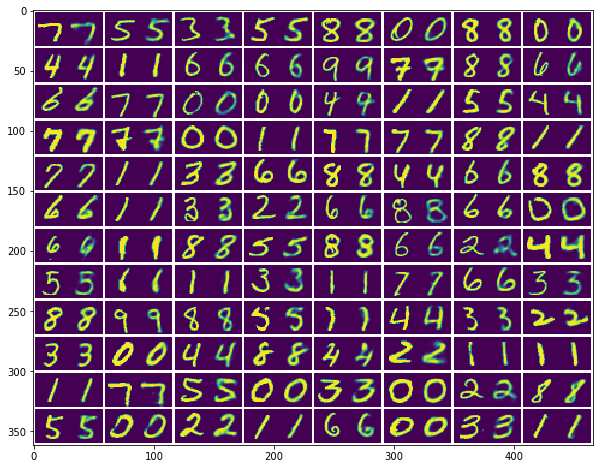

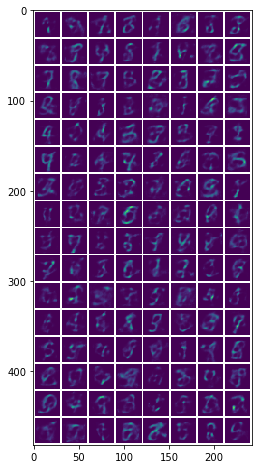

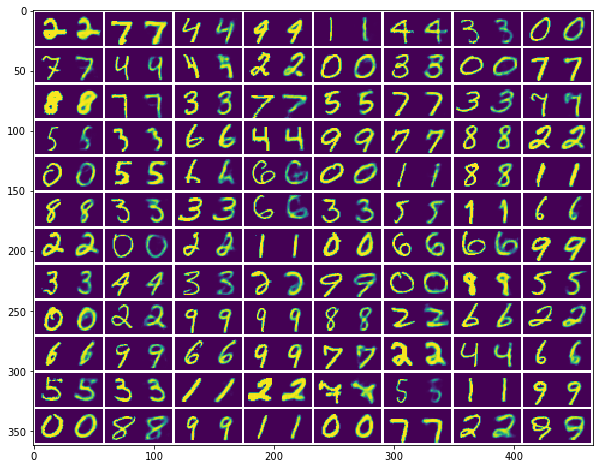

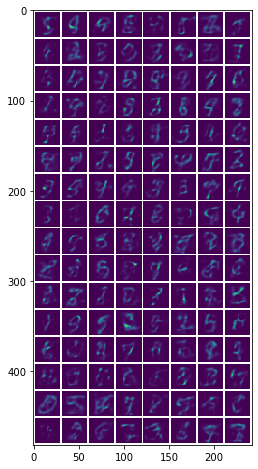

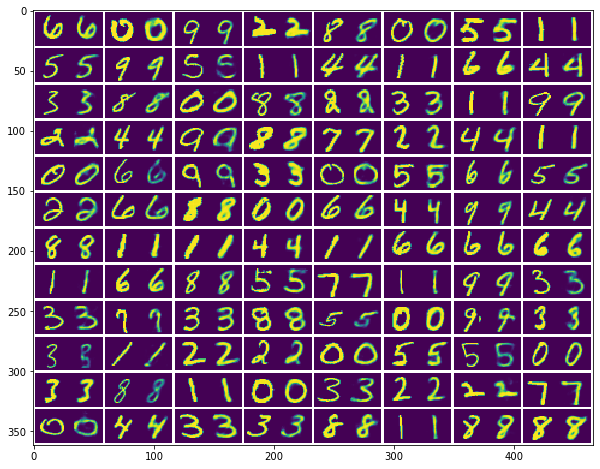

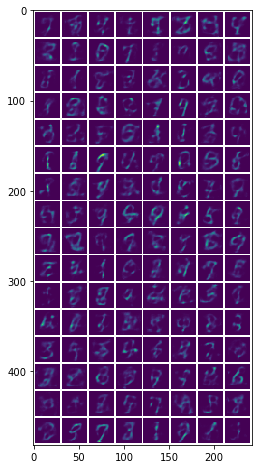

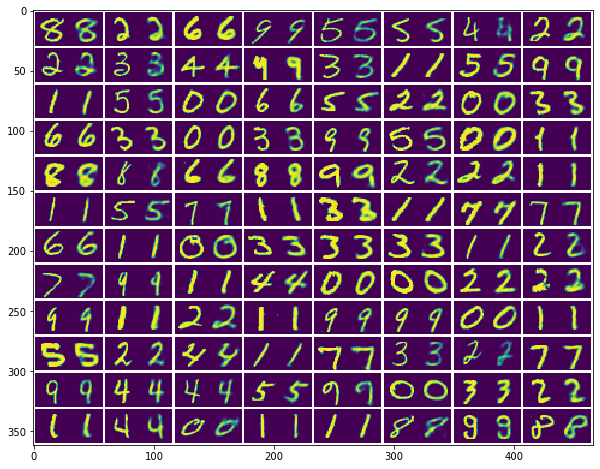

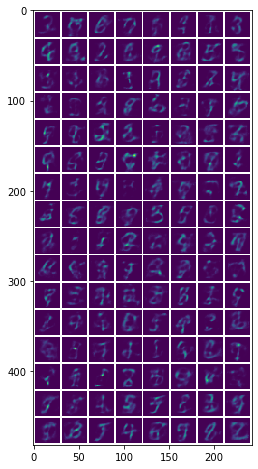

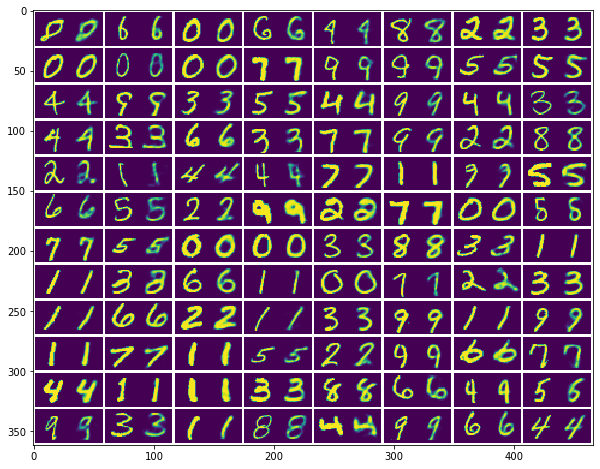

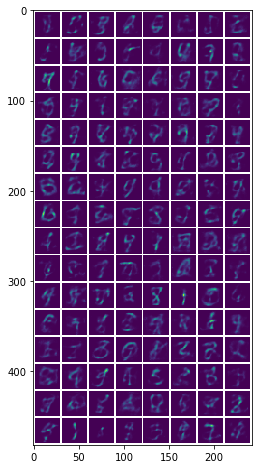

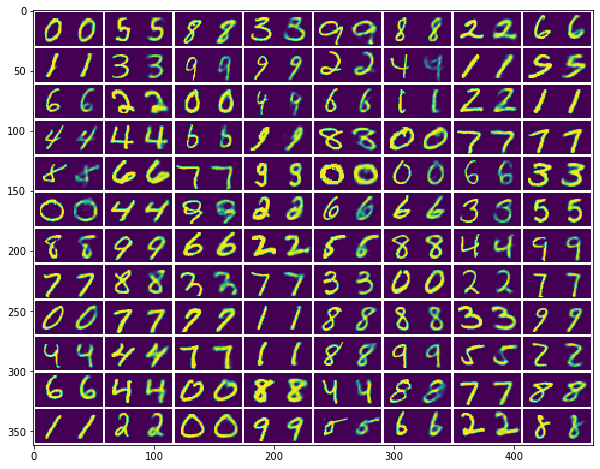

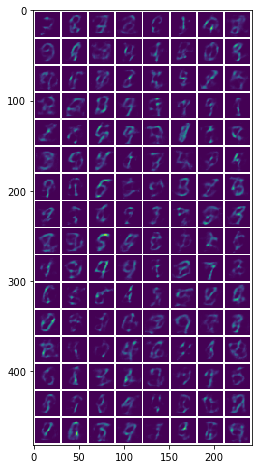

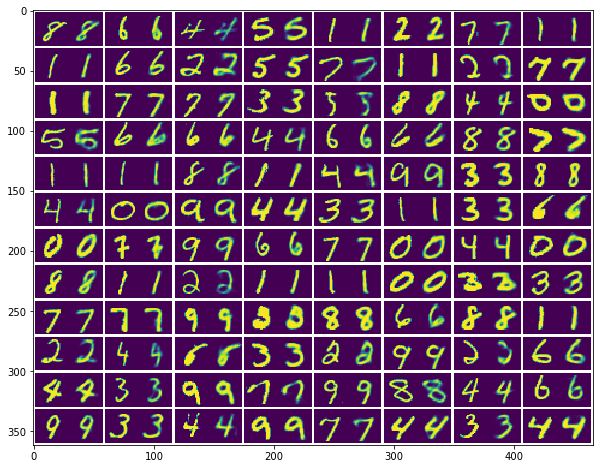

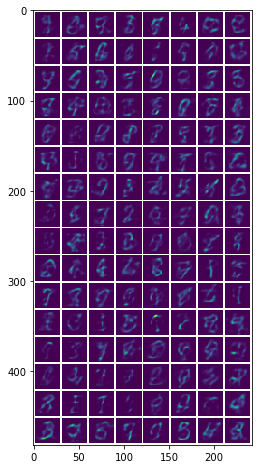

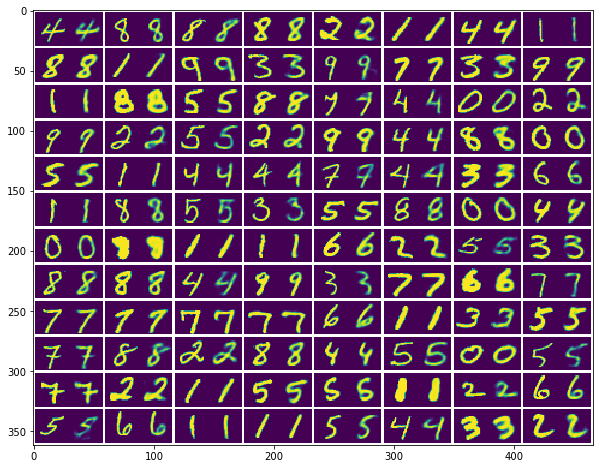

In [30]:
# Defining Parameters
model = MNIST_VAE(MNIST_P)
criterion = Criterion
optimizer = torch.optim.Adam(model.parameters())

# Refresh tqdm bar
tqdm.refresh

# Define model trainer and start training 
model_trainer = Trainer(model, optimizer, criterion, None, '')
model_trainer.run(mnist_dataloder)